# Tensorflow vs PyTorch - SIGNS Dataset

This notebook is an implementation of the coursework from the [Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning) in CNNs - Week 1. 

The objective is replicate the ConvNet for **multiclass classification** in `Pytorch` instead of `Tensorflow` and compare the performance of both frameworks.

* Adapted from: Deep Learning Specialization by Andrew Ng, Coursera
  
  Source: Course Assignment - [Convolutional Neural Networks], Week 1
  
  URL: https://www.coursera.org/specializations/deep-learning
  
  Retrieved: October 2025

## Import libraries/dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Only show errors, not warnings
import tensorflow as tf
import tensorflow.keras.layers as tfl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

train = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_train.csv')
test = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test.csv')

E0000 00:00:1760015454.828348      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760015454.895171      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Preprocessing

In [3]:
print(train.columns)
print(train['label'].unique())
print(len(train))
print(len(test))

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)
[ 3  6  2 13 16  8 22 18 10 20 17 19 21 23 24  1 12 11 15  4  0  5  7 14]
27455
7172


* Each entry from the **SIGNS Dataset** is composed of an image of **784** pixels and a label.
  
* Images correspond to a letter from the English Alphabet in sign language, **J and Z** are not included because to represent them a motion is needed, not just a static pose. There're **25** labels in total.

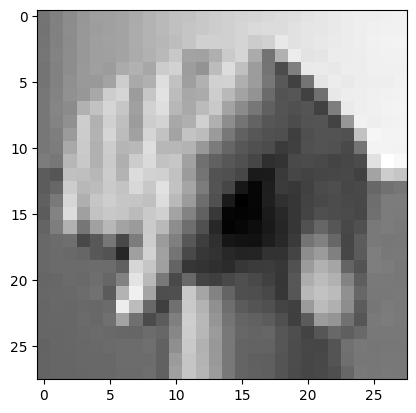

In [5]:
# Split features and labels
Y_train_orig = train['label'].values
X_train_orig = train.drop('label', axis=1).values
Y_test_orig = test['label'].values
X_test_orig = test.drop('label', axis=1).values

# Normalize - Grayscale image pixels
X_train_orig = X_train_orig.astype('float32') / 255.0
X_test_orig  = X_test_orig.astype('float32') / 255.0

index = 69
plt.imshow(X_train_orig[index].reshape(28, 28), cmap='gray')
plt.show()



## 1. Tensorflow (Inspired by Deep Learning Specialization Course)

### 1.1 Data Preprocessing for Tensorflow

In [4]:
# Reshape: 784 pixels - 28x28
X_train_tf = X_train_orig.reshape(-1, 28, 28, 1)
X_test_tf = X_test_orig.reshape(-1, 28, 28, 1)

# Label's encoding
from tensorflow.keras.utils import to_categorical
Y_train_tf = to_categorical(Y_train_orig, num_classes=25)
Y_test_tf = to_categorical(Y_test_orig, num_classes=25)


### 1.2 Convolutional Model

Now comes the implementation of the convolutional model in **Tensorflow**. Inspired by the coursework of the DLS course, i'll use the **Functional API** of Tensorflow, with some adjustments as the dataset is not the same and to imporve performance. 

In [5]:
def convolutional_model(input_shape):
    """
    CONV2D -> BatchNorm -> RELU -> MAXPOOL -> CONV2D -> BatchNorm -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    """
    input_img = tf.keras.Input(shape=input_shape)
    
    # First Conv Block
    Z1 = tfl.Conv2D(32, 3, padding='same')(input_img)
    BN1 = tfl.BatchNormalization()(Z1)
    A1 = tfl.ReLU()(BN1)
    P1 = tfl.MaxPool2D(pool_size=(2,2), strides=2, padding='same')(A1)

    # Second Conv Block
    Z2 = tfl.Conv2D(64, 3, padding='same')(P1)
    BN2 = tfl.BatchNormalization()(Z2)
    A2 = tfl.ReLU()(BN2)
    P2 = tfl.MaxPool2D(pool_size=(2,2), strides=2, padding='same')(A2)

    # Flatten and Dense
    F = tfl.Flatten()(P2)
    D1 = tfl.Dense(128, activation='relu')(F)
    Drop = tfl.Dropout(0.5)(D1)
    outputs = tfl.Dense(25, activation='softmax')(Drop)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

## 1.3 Train - Test

In [6]:
conv_model = convolutional_model((28, 28, 1))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,961 (1.62 MB)

 Trainable params: 423,769 (1.62 MB)

 Non-trainable params: 192 (768.00 B)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tf, Y_train_tf)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_tf, Y_test_tf)).batch(64)
history = conv_model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.1888 - loss: 2.6903 - val_accuracy: 0.3589 - val_loss: 2.0537
Epoch 2/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.4355 - loss: 1.5435 - val_accuracy: 0.7839 - val_loss: 0.7995
Epoch 3/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.5279 - loss: 1.2637 - val_accuracy: 0.7103 - val_loss: 0.9745
Epoch 4/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.5642 - loss: 1.1601 - val_accuracy: 0.7974 - val_loss: 0.6945
Epoch 5/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.5970 - loss: 1.0596 - val_accuracy: 0.7349 - val_loss: 1.0619
Epoch 6/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.6022 - loss: 1.0311 - val_accuracy: 0.8353 - val_loss: 0.6170
Epoch 7/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.6143 - loss: 1.0121 - val_accuracy: 0.8341 - val_loss: 0.5915
Epoch 8/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.6219 - loss: 0.9766 - 

Now we visualize the Accuracy and Loss over epochs:

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

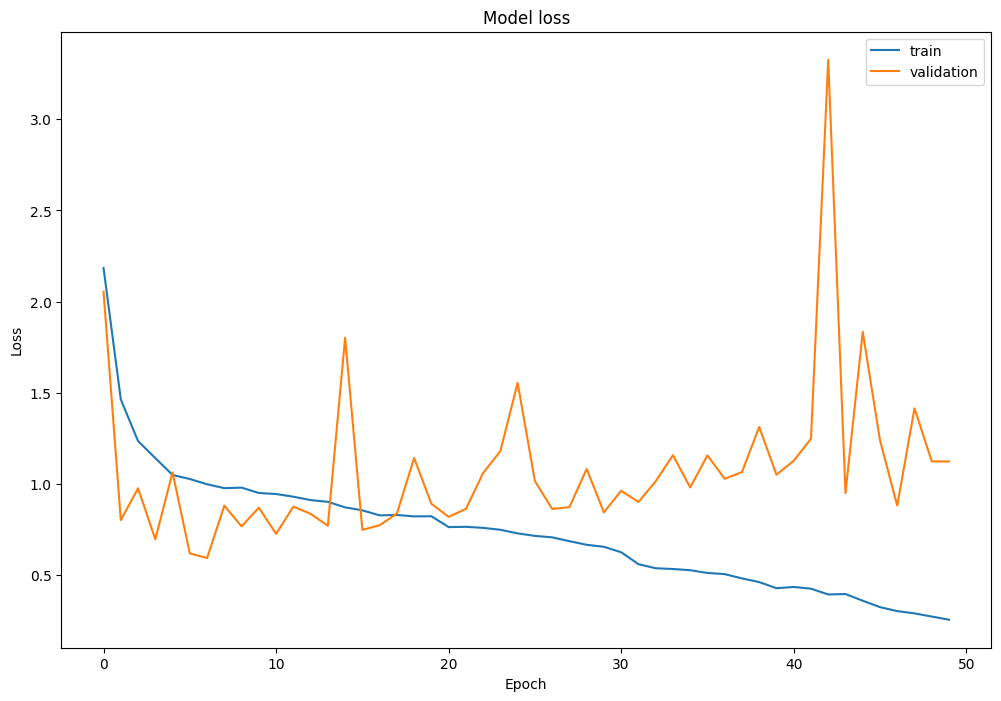

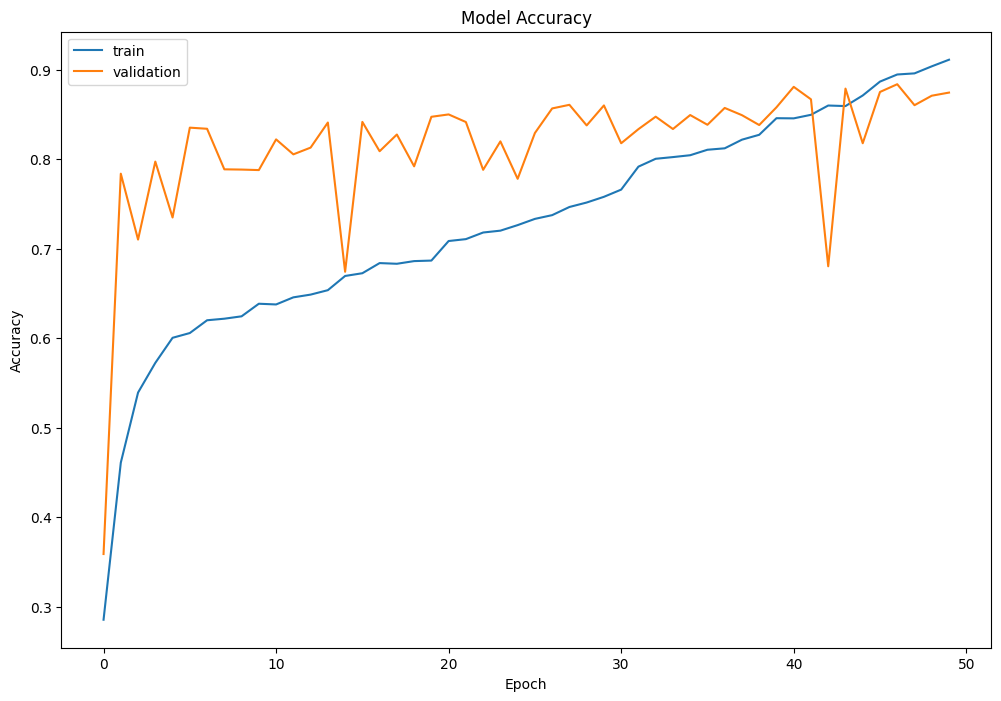

In [9]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss = df_loss.rename(columns={'loss':'train', 'val_loss':'validation'})
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc = df_acc.rename(columns={'accuracy':'train', 'val_accuracy':'validation'})
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

## 2.  PyTorch

### 2.1 Data preprocessing for PyTorch

In [17]:
# Reshape - in Pytorch the shape is channels-first (batch, channels, height, width)
X_train_pt = X_train_orig.reshape(-1, 1, 28, 28)
X_test_pt = X_test_orig.reshape(-1, 1, 28, 28)

# There's no need to encode the labels with Pytorch

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_pt, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_orig, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pt, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_orig, dtype=torch.long)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### 2.2 Convolutional Model

In [13]:
class ConvNetpt(nn.Module):
    def __init__(self):
        super(ConvNetpt, self).__init__()
        # Conv Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Conv Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Flatten is handled in forward
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # After two 2x2 pools, 28x28 -> 14x14 -> 7x7
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 25)  # 25 classes
        
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)  # No softmax; use raw logits for CrossEntropyLoss
        return x

In [15]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
       BatchNorm2d-5           [-1, 64, 14, 14]             128
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 25]           3,225
Total params: 423,769
Trainable params: 423,769
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 1.62
Estimated Total Size (MB): 2.27
-------------------------------------------

In [16]:
# Optimizer and Loss Function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

### 2.3 Training and Validation Loops

In [18]:
n_epochs = 50

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(n_epochs):
    # Training
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()                     # Clear previous gradients
        outputs = model(images)                   # Forward pass
        loss = criterion(outputs, labels)         # Compute Loss
        loss.backward()                           # Backward pass
        optimizer.step()                          # Update Parameters
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    train_loss /= train_total
    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_loss /= val_total
    val_acc = val_correct / val_total

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/50 | Train Loss: 1.1451, Train Acc: 0.6279 | Val Loss: 0.3198, Val Acc: 0.8977
Epoch 2/50 | Train Loss: 0.3636, Train Acc: 0.8715 | Val Loss: 0.2328, Val Acc: 0.9243
Epoch 3/50 | Train Loss: 0.2436, Train Acc: 0.9118 | Val Loss: 0.1674, Val Acc: 0.9448
Epoch 4/50 | Train Loss: 0.2090, Train Acc: 0.9225 | Val Loss: 0.2716, Val Acc: 0.9048
Epoch 5/50 | Train Loss: 0.1820, Train Acc: 0.9318 | Val Loss: 0.2181, Val Acc: 0.9328
Epoch 6/50 | Train Loss: 0.1527, Train Acc: 0.9437 | Val Loss: 0.2652, Val Acc: 0.9332
Epoch 7/50 | Train Loss: 0.1414, Train Acc: 0.9451 | Val Loss: 0.2539, Val Acc: 0.9353
Epoch 8/50 | Train Loss: 0.1438, Train Acc: 0.9448 | Val Loss: 0.3159, Val Acc: 0.9239
Epoch 9/50 | Train Loss: 0.1359, Train Acc: 0.9481 | Val Loss: 0.2819, Val Acc: 0.9382
Epoch 10/50 | Train Loss: 0.1328, Train Acc: 0.9497 | Val Loss: 0.3134, Val Acc: 0.9342
Epoch 11/50 | Train Loss: 0.1207, Train Acc: 0.9541 | Val Loss: 0.2687, Val Acc: 0.9385
Epoch 12/50 | Train Loss: 0.1145, Train A

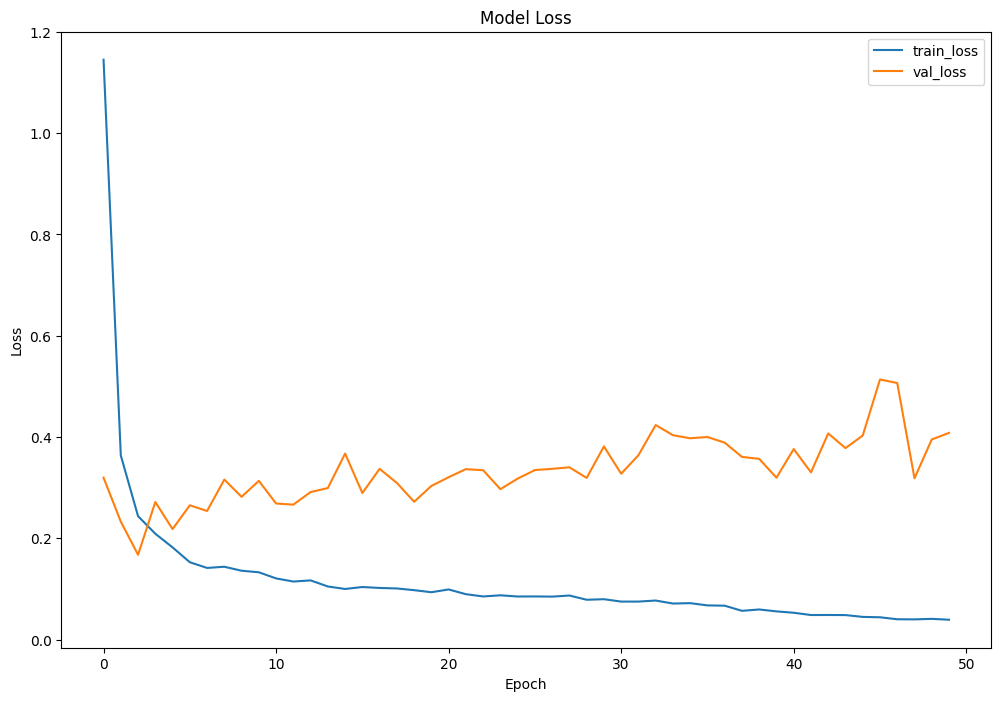

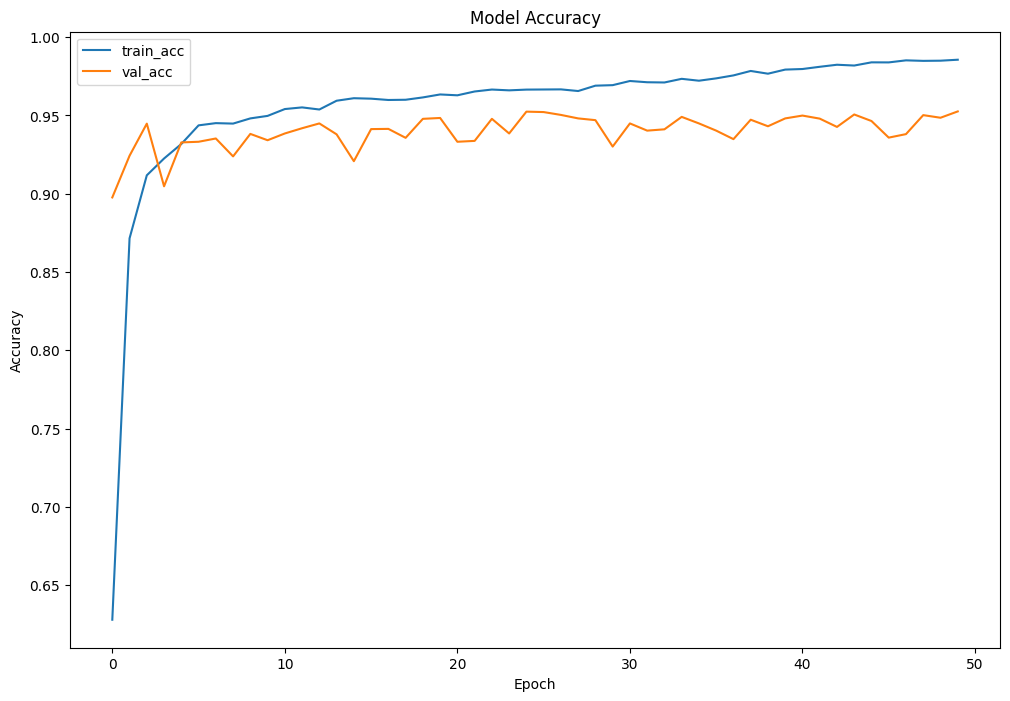

In [19]:
# Plotting Loss/Accuracy:
df_metrics = pd.DataFrame({
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accuracies,
    'val_acc': val_accuracies
})

# Loss
df_metrics[['train_loss', 'val_loss']].plot(title='Model Loss', figsize=(12,8)).set(xlabel='Epoch', ylabel='Loss')
plt.show()

# Accuracy
df_metrics[['train_acc', 'val_acc']].plot(title='Model Accuracy', figsize=(12,8)).set(xlabel='Epoch', ylabel='Accuracy')
plt.show()